In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

2024-03-13 20:55:35.797039: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-13 20:55:36.083019: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 20:55:37.171442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(2115, 22, 1000)


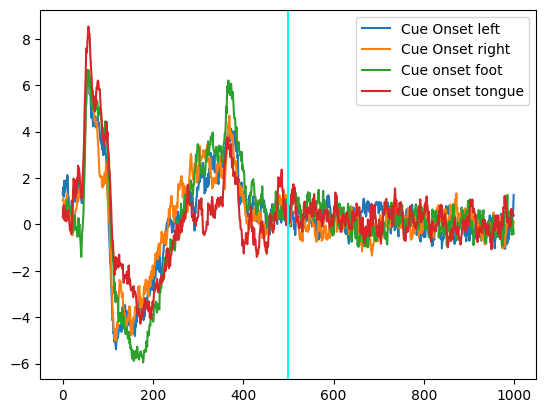

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [3]:
def train_data_prep(X,y,sub_sample,average,noise): # preparation for training samples - Subsampling, Averaging, Noise - data augmentation
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800] # downsampling is equivalent to LPF because Nyquist
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3) # LPF (mean-pooling)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape) # noise for regularization
    
    total_X = np.vstack((total_X, X_average)) # 2100 samples -> 4200 samples (data augmentation)
    total_y = np.hstack((total_y, y))

    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X): # prep the test data
    
    total_X = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X

In [4]:
## Preprocessing the dataset

# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True) #train and validation data
print('Test data prep')
X_test_prep = test_data_prep(X_test) # this is fine, no data leakage

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(X_train_valid.shape[0], X_train_valid.shape[0]//5, replace=False) #5-fold cross validation...?
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
print('Training and testing split')
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

## Random splitting and reshaping the data
# data leakage
# should split into train/val AND THEN do data augmentation
# otherwise we get correlation between training and validation data (model already knows the label from the training)
print('Training data prep')
x_train, y_train = train_data_prep(x_train,y_train,2,2,False) # these are now x_train_prep and y_train_prep
print('Validation data prep')
x_valid, y_valid = train_data_prep(x_valid,y_valid,2,2,False)

print('Categorical conversion (one-hot encoding)')
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

print('Reshaping the data (add width of 1)')
# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


print('Reshaping the data (swap axes)')
# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Test data prep
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Training and testing split
Shape of training set: (1692, 22, 1000)
Shape of validation set: (423, 22, 1000)
Shape of training labels: (1692,)
Shape of validation labels: (423,)
Training data prep
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Validation data prep
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of X after averaging+noise and concatenating: (846, 22, 400)
Shape of X after subsampling and concatenating: (1692, 22, 400)
Shape of Y: (1692,)
Categorical conversion (one-hot encoding)
Shape of training labels after categorical conversion: (6768, 4)
Shape of validation labels after categorical conversion: (1692, 4)
Shape of test labels after cate

In [5]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(400,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()

/home/pmukhopadhyaya/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/home/pmukhopadhyaya/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 400, 1, 25)     │        13,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 134, 1, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 134, 1, 25)     │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 134, 1, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 134, 1, 50)     │        31,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 1, 50)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 1, 50)      │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 1, 50)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 1, 100)     │       125,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 100)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 100)     │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 1, 100)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 1, 200)     │       500,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 1, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 1, 200)      │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 1, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │        40,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 40, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 712,439 (2.72 MB)

 Trainable params: 711,689 (2.71 MB)

 Non-trainable params: 750 (2.93 KB)

In [7]:
# Model parameters
lr = 1e-3
epochs = 100
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(learning_rate=lr)

In [8]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.2603 - loss: 1.3922 - val_accuracy: 0.3026 - val_loss: 1.3748
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.2813 - loss: 1.3766 - val_accuracy: 0.3357 - val_loss: 1.3615
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3036 - loss: 1.3607 - val_accuracy: 0.3398 - val_loss: 1.3329
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3302 - loss: 1.3265 - val_accuracy: 0.3983 - val_loss: 1.2727
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3539 - loss: 1.2944 - val_accuracy: 0.4007 - val_loss: 1.2656
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.3700 - loss: 1.2740 - val_accuracy: 0.4243 - val_loss: 1.2525
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.3838 - loss: 1.2607 - val_accuracy: 0.4332 - val_loss: 1.2342
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.3866 - loss: 1.2492 - 

In [45]:
from keras.layers import GRU, TimeDistributed, MaxPooling1D
from keras.layers import Input, concatenate 
from keras.models import Model

gru_model = Sequential()
# gru_model.add(Reshape((400, 22), input_shape=(400, 1, 22)))

# gru_model.add(GRU(8, return_sequences=True))
# gru_model.add(BatchNormalization())
# gru_model.add(Activation("relu"))
# gru_model.add(Dropout(0.5))

# # gru_model.add(GRU(16, return_sequences=True))
# # gru_model.add(BatchNormalization())
# # gru_model.add(Activation("relu"))
# # gru_model.add(Dropout(0.5))

# gru_model.add(GRU(8, return_sequences=True))
# gru_model.add(BatchNormalization())
# gru_model.add(Activation("relu"))
# gru_model.add(Dropout(0.5))

# gru_model.add(TimeDistributed(Dense(1, activation="relu")))
# gru_model.add(Flatten())
# gru_model.add(BatchNormalization())
# gru_model.add(Dropout(0.5))

# gru_model.add(Dense(40, activation="relu"))
# gru_model.add(BatchNormalization())
# gru_model.add(Dropout(0.5))

# gru_model.add(Dense(4, activation="softmax"))

input_layer = Input(shape=(400, 1, 22))
input_reshape = Reshape((400, 22))(input_layer)

gru_layer1 = GRU(2, return_sequences=True)(input_reshape)
gru_layer2 = GRU(2, return_sequences=True)(gru_layer1)
gru_layer3 = GRU(2, return_sequences=True)(gru_layer2)
gru_layer4 = GRU(2, return_sequences=False)(gru_layer3)

# pool_layer = MaxPooling1D(pool_size=3, padding='same')(input_reshape)

# skip_layer = concatenate([gru_layer2, pool_layer])

output_layer = Dense(4, activation="softmax")(gru_layer4)

gru_model = Model(inputs=input_layer, outputs=output_layer)

gru_model.summary()

Model: "functional_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 400, 1, 22)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_21 (Reshape)            │ (None, 400, 22)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_80 (GRU)                    │ (None, 400, 2)         │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_81 (GRU)                    │ (None, 400, 2)         │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_82 (GRU)                    │ (None, 400, 2)         │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_83 (GRU)                    │ (None, 2)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 4)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276 (1.08 KB)

 Trainable params: 276 (1.08 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
lr = 1e-3
gru_optimizer = keras.optimizers.Adam(learning_rate=lr)

gru_model.compile(loss='categorical_crossentropy', 
                  optimizer=gru_optimizer, 
                  metrics=['accuracy'])

epochs = 40
gru_model_results = gru_model.fit(x_train,
             y_train,
             batch_size=128,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 516ms/step - accuracy: 0.2557 - loss: 1.3902 - val_accuracy: 0.2518 - val_loss: 1.3878
Epoch 2/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 509ms/step - accuracy: 0.2722 - loss: 1.3863 - val_accuracy: 0.2500 - val_loss: 1.3874
Epoch 3/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 536ms/step - accuracy: 0.2592 - loss: 1.3860 - val_accuracy: 0.2488 - val_loss: 1.3873
Epoch 4/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 546ms/step - accuracy: 0.2698 - loss: 1.3851 - val_accuracy: 0.2429 - val_loss: 1.3879
Epoch 5/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 542ms/step - accuracy: 0.2729 - loss: 1.3846 - val_accuracy: 0.2577 - val_loss: 1.3880
Epoch 6/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 532ms/step - accuracy: 0.2776 - loss: 1.3824 - val_accuracy: 0.2541 - val_loss: 1.3878
Epoch 7/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 535ms/step - accuracy: 0.2830 - loss: 1.3823 - val_accuracy: 0.2447 - val_loss: 1.3886
Epoch 8/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 526ms/step - accuracy: 0.2772 - loss: 1.3813 - val_accu

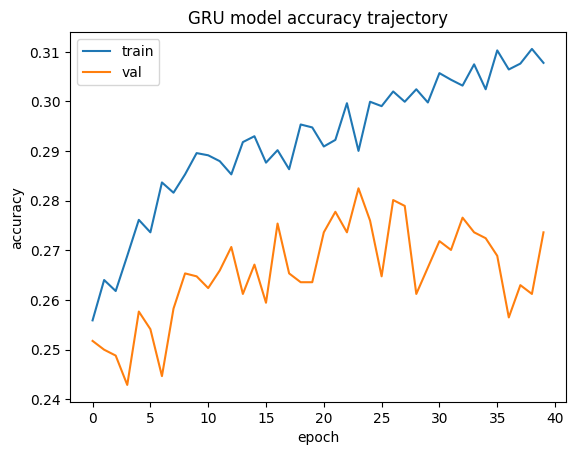

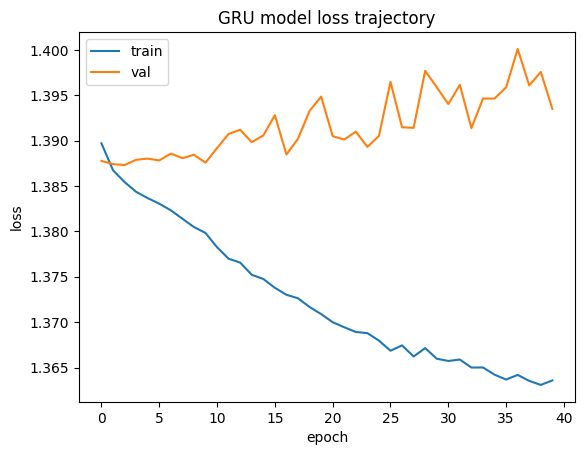

Test accuracy of the GRU model: 0.2663656771183014


In [47]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(gru_model_results.history['accuracy'])
plt.plot(gru_model_results.history['val_accuracy'])
plt.title('GRU model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(gru_model_results.history['loss'])
plt.plot(gru_model_results.history['val_loss'])
plt.title('GRU model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

gru_score = gru_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the GRU model:', gru_score[1])